<a href="https://colab.research.google.com/github/tirtharajdash/BITS-G513_MetaLearning/blob/main/Lab_4A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline
1. Audio Data
2. CNNs on Audio

## Audio Data


#### Setup

In [33]:
!git clone https://github.com/Atcold/pytorch-Deep-Learning
import sys
sys.path.append(f"/content/pytorch-Deep-Learning")
from res.plot_lib import set_default


x[k] has 70641 samples
the sampling rate is 22.05kHz
x(t) is 3.2s long


Text(0.5, 1.0, '$x(t)$')

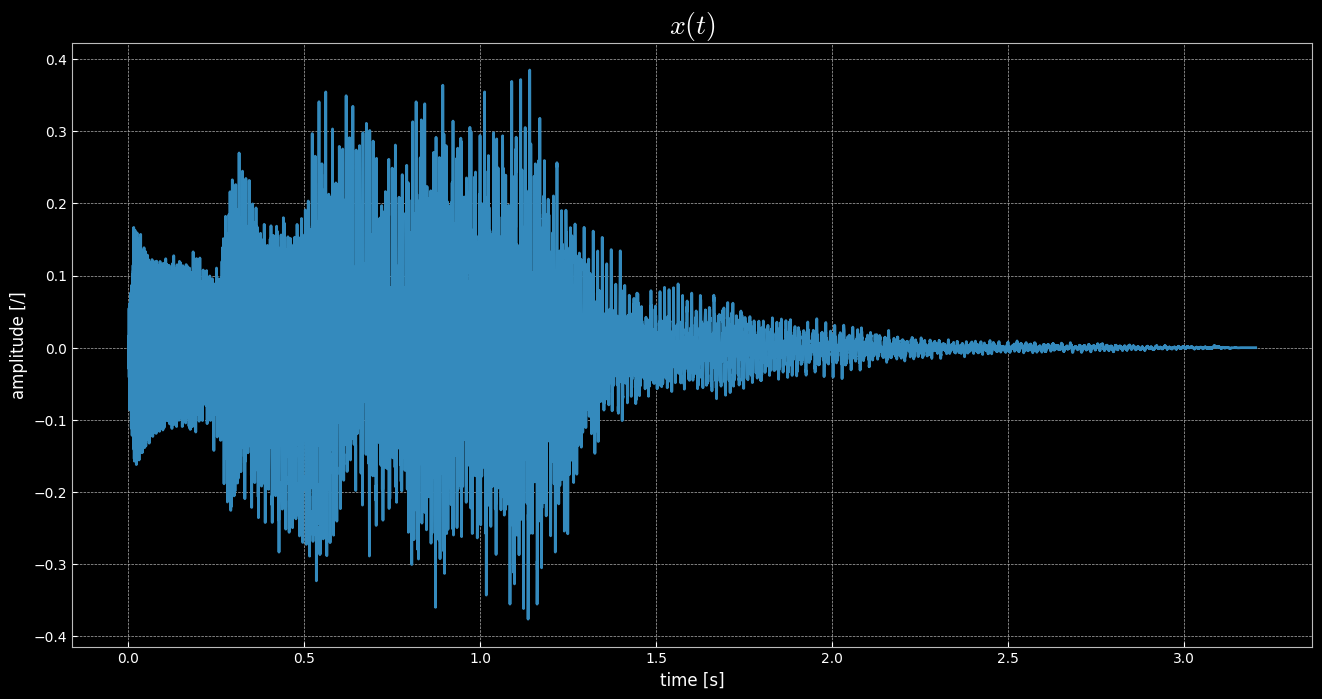

In [47]:
set_default(figsize=(16, 8))

x, sampling_rate = librosa.load("/content/pytorch-Deep-Learning/res/win_xp_shutdown.wav")

T = x.size / sampling_rate
print(
    f'x[k] has {x.size} samples',
    f'the sampling rate is {sampling_rate * 1e-3}kHz',
    f'x(t) is {T:.1f}s long'
    , sep='\n')

# Create x(t) time span
dt = 1 / sampling_rate
t = np.r_[0:T:dt]

# Visualise x(t)
plt.figure()
plt.plot(t, x)
plt.xlabel('time [s]')
plt.ylabel('amplitude [/]')
plt.title(r'$x(t)$', size=20)

In [48]:
Audio(x, rate=sampling_rate)


In [50]:
# Compute Short-time Fourier transform (STFT) and convert the amplitude to dB
X = librosa.stft(x)
X_dB = librosa.amplitude_to_db(np.abs(X))

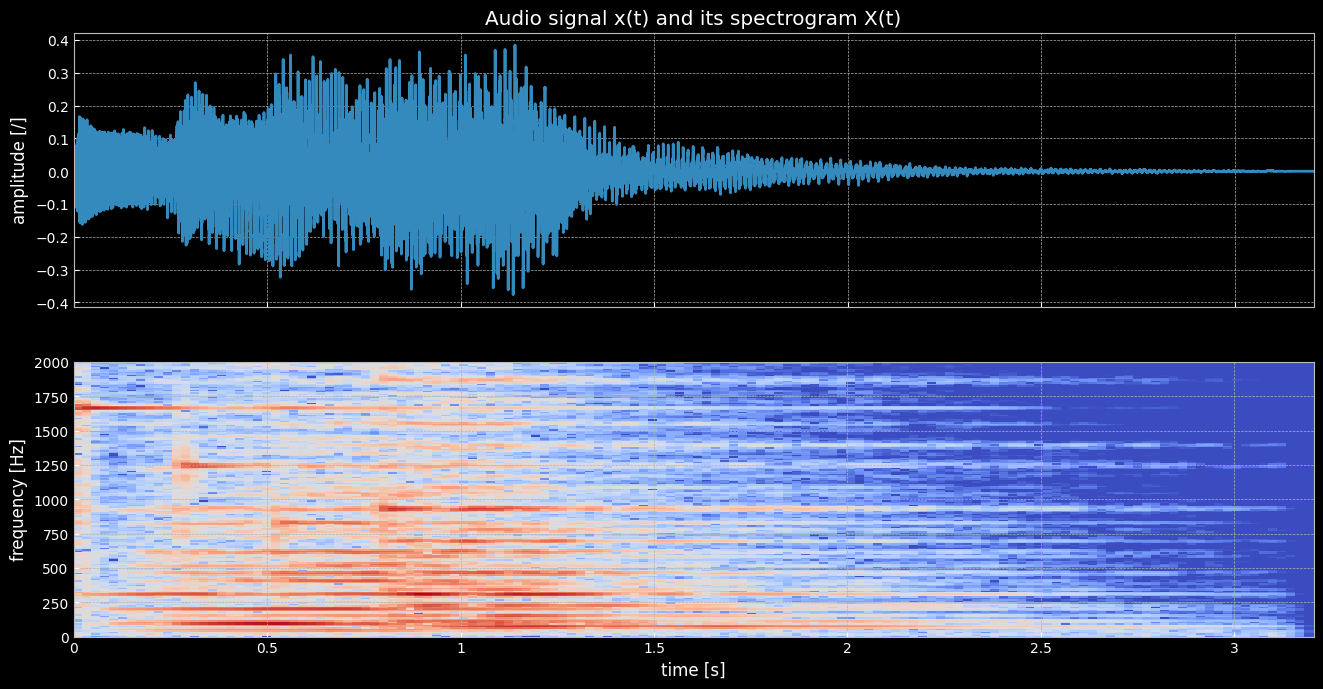

In [51]:
from librosa.display import specshow
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, x)
plt.xlim([0, T])
plt.ylabel('amplitude [/]')
plt.title('Audio signal x(t) and its spectrogram X(t)')
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.subplot(2,1,2)
specshow(X_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.ylim(top=2000)
plt.grid(True)

In [52]:
Ab6 = 1661  # Hz
Eb6 = 1244  # Hz
Ab5 = 830   # Hz
Bb5 = 932   # Hz
TT = .4  # s
tt = np.r_[0:TT:dt]

# generate tones
A = {
    'a^(1)': np.sin(2 * np.pi * Ab6 * tt),
    'a^(2)': np.sin(2 * np.pi * Eb6 * tt),
    'a^(3)': np.sin(2 * np.pi * Ab5 * tt),
    'a^(4)': np.sin(2 * np.pi * Bb5 * tt),
}

# and concatenate them
xx = np.concatenate([a[1] for a in A.items()])

# Let's listen to the original and the reconstructed
display(Audio(x, rate=sampling_rate))
display(Audio(xx, rate=sampling_rate))

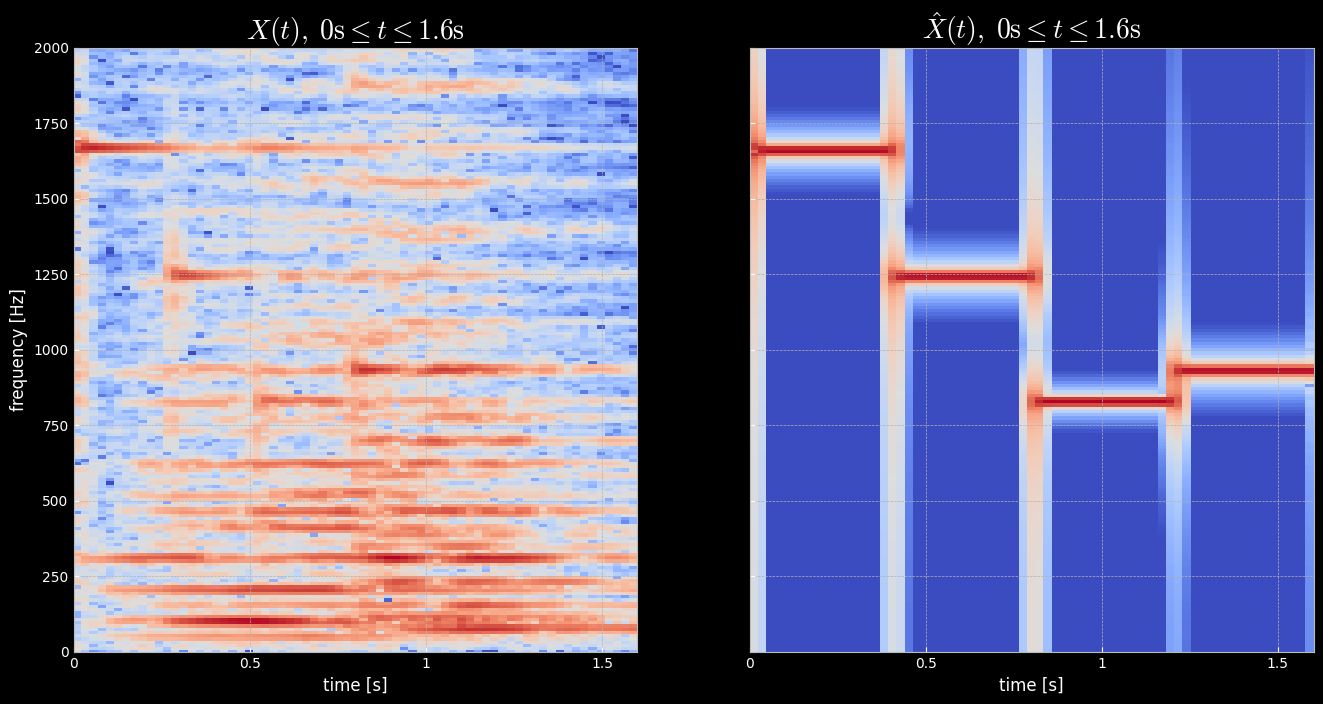

In [53]:
XX = librosa.stft(xx)
XX_dB = librosa.amplitude_to_db(np.abs(XX))

plt.figure()
t_string = r'$0\mathrm{s} \leq t \leq 1.6\mathrm{s}$'

plt.subplot(1,2,1)
specshow(X_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.ylim(ymax=2000)
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.grid(True)
plt.xlim(right=1.6)
plt.title(r'$X(t),\; $' + t_string, size=20)

plt.subplot(1,2,2)
specshow(XX_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.xlabel('time [s]')
plt.ylim(top=2000)
plt.ylabel('')
plt.grid(True)
plt.title(r'$\hat X(t),\; $' + t_string, size=20);

Text(0.5, 0, 'samples [/]')

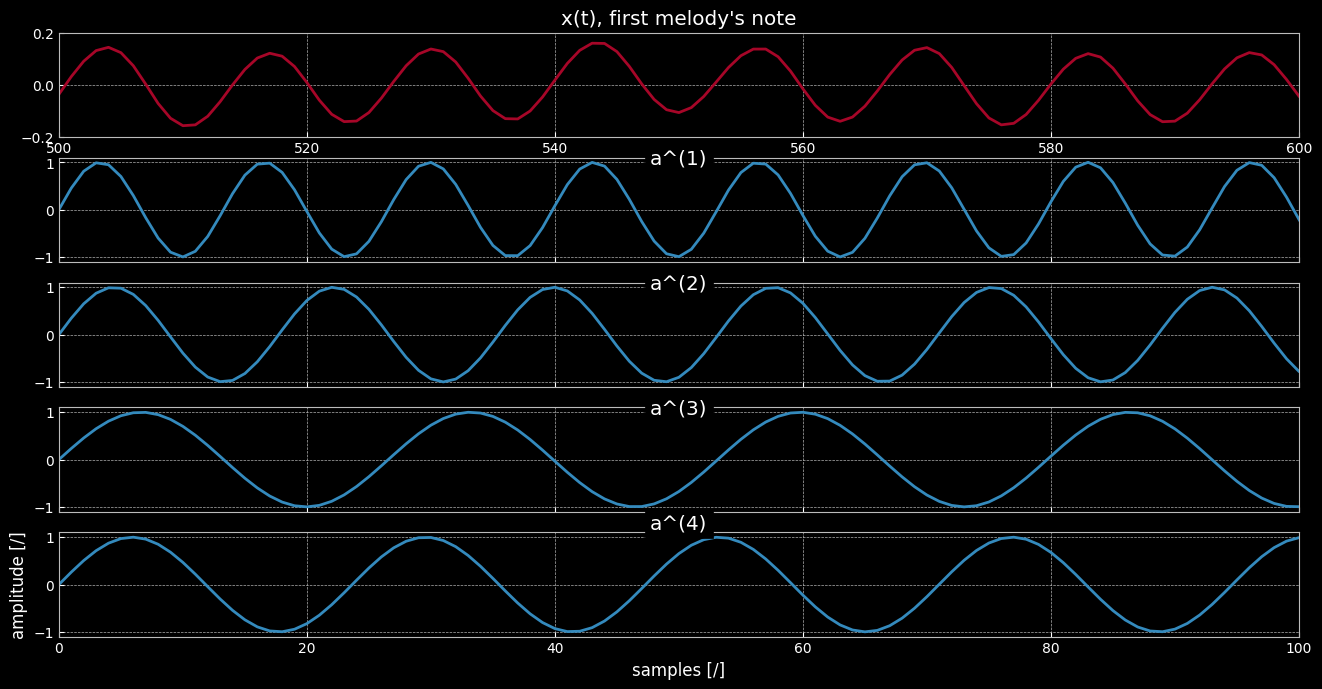

In [54]:
plt.figure()
plt.subplot(5, 1, 1)
plt.title('x(t), first melody\'s note')
plt.plot(x, 'C1')
plt.xlim([500, 600])
plt.ylim([-.2, .2])
i = 2
for a in A.items():
    plt.subplot(5, 1, i)
    i += 1
    plt.plot(a[1])
    plt.xlim([0, 100])
    plt.title(a[0], verticalalignment='top', backgroundcolor='black')
    if i < 6: 
        plt.setp(plt.gca().get_xticklabels(), visible=False)

plt.ylabel('amplitude [/]')
plt.xlabel('samples [/]')

Text(0.5, 0, 'time [s]')

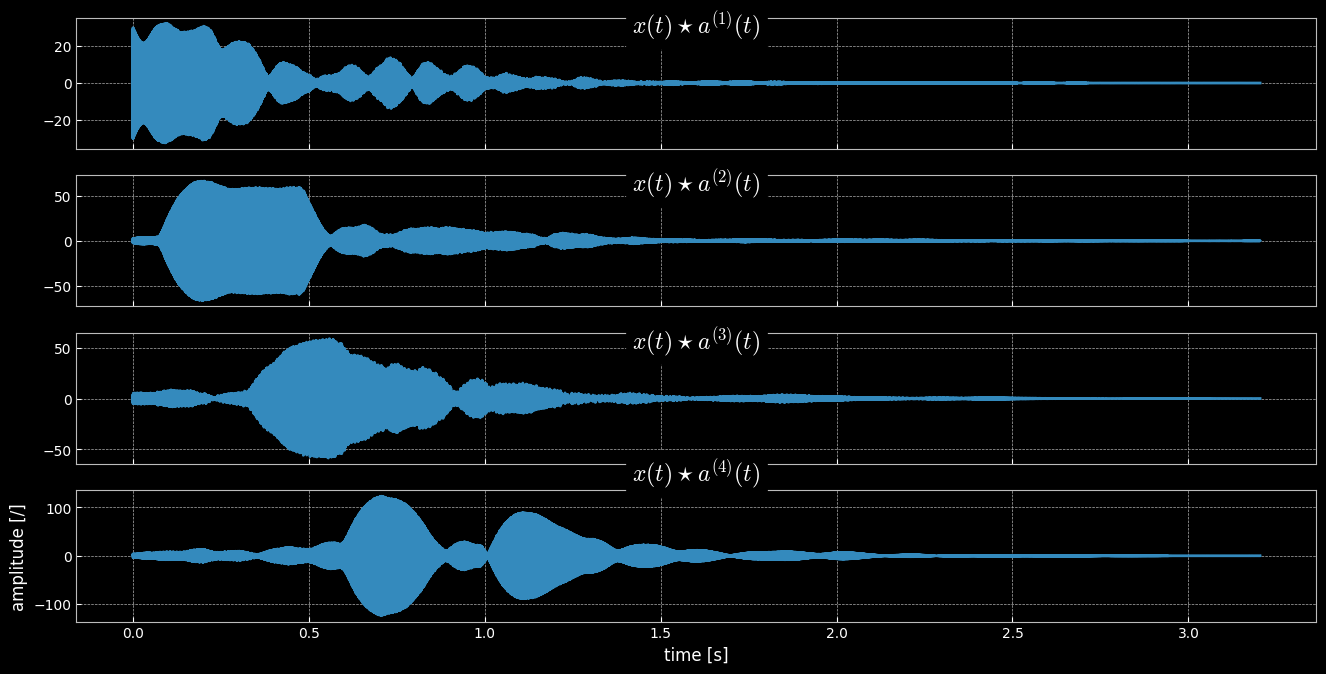

In [55]:
plt.figure()
convs = list()
n = 1
for a in A.items():
    plt.subplot(4, 1, n)
    plt.title(rf'$x(t) \star a^{{({n})}}(t)$', backgroundcolor='black', verticalalignment='top', size=17)
    n += 1
    convs.append(np.convolve(x, a[1], mode='same'))
    plt.plot(t, convs[-1])
    if n < 5: 
        plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.ylabel('amplitude [/]')
plt.xlabel('time [s]')

In [56]:
for c in convs:
    display(Audio(c, rate=sampling_rate))

## CNNs on Audio

In [1]:
import os, librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%%bash

wget https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip
wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

mkdir songs_data && cd songs_data & cd ../
unzip ../Audio_Song_Actors_01-24.zip
mkdir speech_data && cd speech_data
unzip ../Audio_Speech_Actors_01-24.zip

In [ ]:
modality = {'01':'full_av','02':'video_only','03':'audio_only'}
vocal_channel = {'01':'speech','02':'song'}
emotion = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
emotional_intensity = {'01':'normal','02':'strong'}
statement = {'01':'Kids are talking by the door','02':'Dogs are sitting by the door'}
reptition = {'01':'first_repitition','02':'second_repetition'}
def actor_f(num):
    if int(num)%2==0: return('female')
    else: return('male')

actors = sorted(os.listdir('./speech_data'))
# actors.pop()
actors

In [7]:
audio_file_dict = {}
for actor in actors:
    actor_dir = os.path.join('./speech_data',actor)
    actor_files = os.listdir(actor_dir)
    actor_dict = [i.replace(".wav","").split("-") for i in actor_files]
    dict_entry = {os.path.join(actor_dir,i):j for i,j in zip(actor_files,actor_dict)}
    audio_file_dict.update(dict_entry)

In [8]:
audio_file_dict = pd.DataFrame(audio_file_dict).T
audio_file_dict.columns = ['modality','vocal_channel','emotion','emotional_intensity','statement','repetition','actor']
audio_file_dict

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor
./speech_data/Actor_01/03-01-05-01-02-02-01.wav,03,01,05,01,02,02,01
./speech_data/Actor_01/03-01-04-02-02-02-01.wav,03,01,04,02,02,02,01
./speech_data/Actor_01/03-01-08-01-02-01-01.wav,03,01,08,01,02,01,01
./speech_data/Actor_01/03-01-03-01-01-01-01.wav,03,01,03,01,01,01,01
./speech_data/Actor_01/03-01-04-01-02-01-01.wav,03,01,04,01,02,01,01
...,...,...,...,...,...,...,...
./speech_data/Actor_24/03-01-04-01-01-01-24.wav,03,01,04,01,01,01,24
./speech_data/Actor_24/03-01-07-01-01-02-24.wav,03,01,07,01,01,02,24
./speech_data/Actor_24/03-01-04-01-02-01-24.wav,03,01,04,01,02,01,24
./speech_data/Actor_24/03-01-03-01-01-02-24.wav,03,01,03,01,01,02,24


In [57]:
for i in range(0,3):
    audio, sr = librosa.load(audio_file_dict.index[i],res_type='kaiser_fast')
    print(emotion[audio_file_dict.index[i].split('/')[-1][6:8]])
    display(Audio(audio, rate=sr))

angry


sad


surprised


In [9]:
audio_file_dict.modality = audio_file_dict.modality.map(modality)
audio_file_dict.vocal_channel = audio_file_dict.vocal_channel.map(vocal_channel)
audio_file_dict.emotion = audio_file_dict.emotion.map(emotion)
audio_file_dict.emotional_intensity = audio_file_dict.emotional_intensity.map(emotional_intensity)
audio_file_dict.statement = audio_file_dict.statement.map(statement)
audio_file_dict.repetition = audio_file_dict.repetition.map(reptition)
audio_file_dict['actor_sex'] = audio_file_dict.actor.apply(actor_f)

In [10]:
!pip install torchaudio
import torchaudio
from tqdm import tqdm

audio_files = []
for i in tqdm(list(audio_file_dict.index)):
    i, _ = torchaudio.load(i)
    audio_files.append(i)

spectrograms = []
for i in tqdm(audio_files):
    specgram = torchaudio.transforms.Spectrogram()(i)
    spectrograms.append(specgram)

max_width = max([i.shape[2] for i in spectrograms])
max_height = max([i.shape[1] for i in spectrograms])

     |████████████████████████████████| 7.6MB 8.7MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, 

In [59]:
lst = []

from tqdm import tqdm
import time
start_time = time.time()

for i in tqdm(list(audio_file_dict.index)):
    try:
        # Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(i,res_type='kaiser_fast')
        mfcc = librosa.feature.mfcc(y=X, sr=sample_rate,n_mfcc=40).T
        mfccs = np.mean(mfcc, axis=0)
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        # print(i)
        i = int(i.split('/')[-1][7:8]) - 1
        arr = mfccs, i
        lst.append(arr)
    # If the file is not valid, skip it
    except ValueError as err:
        print(err)
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

# Array conversion
X, y = np.asarray(X), np.asarray(y)

100%|██████████| 1440/1440 [01:37<00:00, 14.71it/s]

--- Data loaded. Loading time: 97.89737319946289 seconds ---


(1440, 40)

In [60]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torch

class EmotionDatasetMFCC(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index): 
        audio_features = torch.from_numpy(self.X[index,:])
        label = torch.as_tensor([self.y[index]])
        return (audio_features, label)

    def __len__(self):
        count = max(self.X.shape)
        return count

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, audio_file_dict):
        self.audio_file_dict = audio_file_dict.reset_index()

        
    def __getitem__(self, index): 
        
            img = self.audio_file_dict.reset_index()['index'][index]
            img, _ = torchaudio.load(img)
            img = torch.mean(img, dim=0).unsqueeze(0)
            img = torchaudio.transforms.Spectrogram()(img)
            img = F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])
            
            
            label = list(pd.get_dummies(self.audio_file_dict.reset_index().emotion).iloc[index].values)
            label = np.array(label)
            label = torch.from_numpy(label)
            return (img, label)

    def __len__(self):
        count = len(self.audio_file_dict)
        return count

In [67]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.layer1 = nn.Conv1d(1, 32, 5, stride=2)
        self.drop_out = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(576, 8)
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        # print(out.shape)
        out = self.fc2(out)
        return out

model = ConvNet2()

learning_rate = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [69]:
from tqdm import trange

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

batch_size=64

train_data = EmotionDatasetMFCC(X_train, y_train)
test_data = EmotionDatasetMFCC(X_test, y_test)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

model.cuda()

# Train the model
total_step = len(train_loader)

num_epochs = 250

t = trange(num_epochs, position=0, leave=True)

best = float('-inf')

for epoch in t:
    t.set_description(f'Epoch {i+1}')
    loss_list = []
    acc_list = []
    test_acc_list = []
    for i, (input, labels) in enumerate(train_loader):
        
        # Run the forward pass
        input = input.cuda().unsqueeze(-2)
        # labels = torch.max(labels, 1)[1].cuda()
        labels = labels.squeeze().cuda()
        
        outputs = model(input)
        _, predicted = torch.max(outputs.data, 1)
        # print(">>", predicted, predicted.shape, predicted, labels)
        
        loss = criterion(outputs, labels.squeeze())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
    # print(f'epoch: {epoch}: acc:',np.mean(acc_list),'loss: ',np.mean(loss_list))

    train_acc = round(np.mean(acc_list), 2)
    train_loss = round(np.mean(loss_list), 2)

    model.eval()

    preds = []
    outcome = []
    labs = []
    with torch.no_grad():
        for data in test_loader:
            input, labels = data
            input = input.cuda()
            labels = labels.cuda()
            labs.append(labels)
            outputs = model(input.unsqueeze(-2))
            _, predicted = torch.max(outputs, 1)
            # print(predicted.shape, labels.shape)
            preds.append(predicted)
            c = (predicted == labels.squeeze()).squeeze()
            outcome.extend(c.tolist())

    outcome = torch.as_tensor(outcome).view(-1).cpu().numpy()
    test_acc_list.append(100*round(outcome.sum()/len(outcome),2))
    
    
    t.set_postfix(train_accuracy = train_acc * 100, test_accuracy = test_acc_list[-1])

    if test_acc_list[-1] > best:
        torch.save(model.state_dict(), "best_model.h5")



Epoch 16: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s, test_accuracy=53, train_accuracy=72]


In [71]:
model.load_state_dict(torch.load("best_model.h5"))

<All keys matched successfully>

In [72]:
model.eval()

preds = []
outcome = []
labs = []
with torch.no_grad():
    for data in test_loader:
        input, labels = data
        input = input.cuda()
        labels = labels.cuda()
        labs.append(labels)
        outputs = model(input.unsqueeze(-2))
        _, predicted = torch.max(outputs, 1)
        # print(predicted.shape, labels.shape)
        preds.append(predicted)
        c = (predicted == labels.squeeze()).squeeze()
        # print(c.shape)
        outcome.extend(c.tolist())

outcome = torch.as_tensor(outcome).view(-1).cpu().numpy()
print('Accuracy on test set after 50 epochs: ',
      100*round(outcome.sum()/len(outcome),2),'%')

Accuracy on test set after 50 epochs:  53.0 %


### Other things to try out:
- Perhaps dont take a mean of the MFCCs?
- Treat Spectrogram as an "image"
- Play around with the architectures
  - Different kernel size, padding, dilation, etc in Convolutions. How do these affect learning? 
  - Try Pooling. In particular, Average Pooling
  - Batch norm 2d in Spectrogram + Conv2D
